Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [9]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8015043877977435


In [10]:
X_train.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
45793,41413,0.0,2011-03-30,NaN,0,NaN,33.075583,-9.385449,Kwa Mwazembe,0,Lake Nyasa,Itaba,Mbeya,12,5,Ileje,Chitete,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


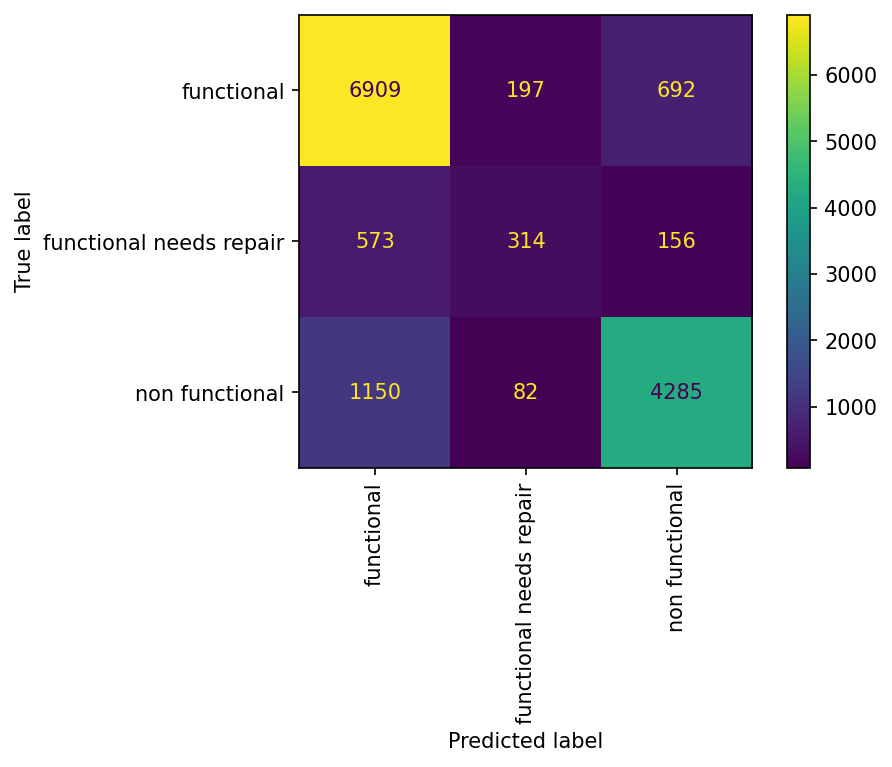

In [12]:
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.dpi'] = 150
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [13]:
correct_pred = 6909 + 314 + 4285
correct_pred

11508

In [14]:
total_pred = 6909 + 314 + 4285 + 573 + 1150 + 197 + 82 + 692 + 156
total_pred

14358

In [15]:
correct_pred / total_pred

0.8015043877977435

In [16]:
accuracy_score(y_val, y_pred)

0.8015043877977435

In [18]:
print(classification_report(y_val, y_pred))

NameError: ignored

In [20]:
y_train = y_train != 'functional'

In [22]:
y_val = y_val != 'functional'

In [23]:
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [24]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

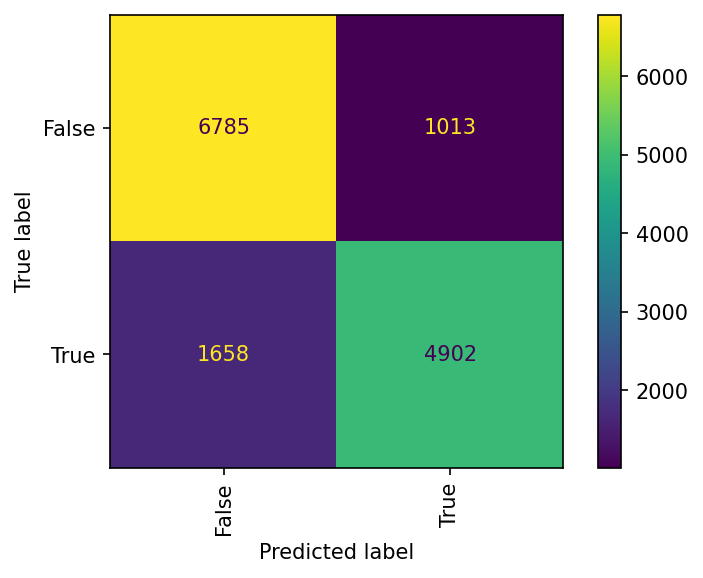

In [25]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [27]:
recall = 4902 / (4902 + 1658)
recall

0.7472560975609757

In [26]:
print(classification_report(y_val, y_pred))

NameError: ignored

In [28]:
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)

In [29]:
print(y_pred[:10])

[ True  True False False  True False False False  True False]


In [30]:
print(y_pred_proba[:10])

[[0.   1.  ]
 [0.3  0.7 ]
 [0.9  0.1 ]
 [0.9  0.1 ]
 [0.45 0.55]
 [0.9  0.1 ]
 [0.7  0.3 ]
 [0.65 0.35]
 [0.   1.  ]
 [0.85 0.15]]


In [31]:
len(test)

14358

In [32]:
len(train) + len(val)

59400

In [33]:
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [34]:
random_inspections = 2000
print(f'With {random_inspections} random inspections, we expect to repair {0.46*random_inspections} waterpumps')

With 2000 random inspections, we expect to repair 920.0 waterpumps


In [35]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


True    1.0
Name: status_group, dtype: float64

In [36]:
len(val) == len(test)

True

In [37]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [39]:
threshold = .925
y_pred_prec = y_pred_proba[:,-1] > threshold

In [40]:
y_pred_proba[:,-1]

array([1.  , 0.7 , 0.1 , ..., 0.25, 0.65, 0.  ])

In [41]:
y_pred_prec[:10]

array([ True, False, False, False, False, False, False, False,  True,
       False])

In [43]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_prob': y_pred_proba[:,-1]})

results.head()

,y_val,y_pred_prob
58046,True,1.00
41184,True,0.70
27587,True,0.10
53109,True,0.10
7245,True,0.55


In [44]:
top2000 = results.sort_values(by='y_pred_prob', ascending=False)[:2000]

In [45]:
top2000.head()

,y_val,y_pred_prob
58046,True,1.0
34327,True,1.0
32398,True,1.0
3735,True,1.0
55074,True,1.0


In [46]:
trips = 2000
print(f'Baseline: {trips * 0.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model: Predict 2000 waterpump repairs in 2000 trips


In [47]:
print('Precision @ k=2000', relevant_recommendations / trips)

Precision @ k=2000 1.0
